In [2]:
# ce notebook fait une analyse du retard en fonction du temps pour des faibles retards 
import numpy as np 
import pandas as pd 
import scipy as sc 
import matplotlib.pyplot as plt 
from itertools import product
from sklearn import linear_model
from sklearn.utils import shuffle
import seaborn as sns

import missingno as msno

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import kernel_ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import dummy
from sklearn.metrics import f1_score

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)

import timeit

In [3]:
# ouvrir le dataset : 

data_fly = pd.read_csv('DF_CASCADE_DEST.csv')

In [ ]:
df = data_fly.copy()
valeur = plot_value_counts('PROBLEM_BIG')

In [ ]:
print (valeur)

In [ ]:
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
explode=(0, 0.5)
plt.pie([275197,4838], explode=explode, labels=['pas de gros problème','gros problème'], autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Proportion de cas de gros retard annulation ou déviation')
plt.axis('equal')
plt.savefig('pict_bigprob.png', dpi=400)
plt.show()

In [ ]:
data_fly.columns[:]

In [ ]:
def plot_value_counts(col_name):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    
    return (values_count)

On annalyse ici différent modèles de regressions logistiques avec ou sans régularisation en fonction des différentes variables prises en compte.
Trois étapes de temps sont à considérer : En premier lieu le retard prévisible longtemps à l'avance ( on base notre analyse sur le reppart au départ ) Ensuite le retard prévisible quelques heures à l'avance ( on base notre analyse sur le retard au départ ) enfin le retard prévisible une fois que l'on connait l'heure de départ de l'avion ( on base notre analyse sur le retard à l'arrivé )

Tous nos modèles vont être testé via une validation croisée sur le jeux d'entrainement, un pré-choix des différents paramétres de régularisation sera effectué via une validation croisée par grille sur la base de l'aire sous la courbe ROC. Le choix final se fera lui aussi sur la base de la meilleure aire sous courbe ROC. (on ne tient pas compte d'éventuelles restrictions de temps de calcul). Enfin, la performance du modèle final sera donnée en l'évaluant via le jeux de test. Le modèle final pourra ensuite être entrainé sur l'ensemble du jeux de donnée.

On cherche ici à savoir si un avion va avoir ou non un problème grave (on prend en compte ici les retards forts de plus de 300 mins ou les annulations ou les diversions).

On définie une fonction qui analyse via une cross-validation sur 5 folds les retards de regression logistiques simples non régularisées. 

In [5]:
def analyse(X_fit,y_fit,n):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2           
    
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # On crée un modèle de régression logistique

    lr = LogisticRegression(penalty='l2',C=10000,dual=False)
    # évaluation de la rmse par validation croisée (sur 5 folds)
    y_predict_lr = cross_val_predict(lr,X_fit,y_fit,method='predict_proba',cv=5)
    y_predict_lr_occ = cross_val_predict(lr,X_fit,y_fit,cv=5)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):    
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    

    return (f1_sc,accu,roc_auc)
    
    

In [6]:
def analyse_stoch(X_fit,y_fit,n):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2           
    
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # On crée un modèle SVM avec descente de gradient stochastique

    lr = linear_model.SGDClassifier(loss='log',max_iter=15,penalty=None,learning_rate='optimal')
    # évaluation de la rmse par validation croisée (sur 5 folds)
    y_predict_lr = cross_val_predict(lr,X_fit,y_fit,method='predict_proba',cv=5)
    y_predict_lr_occ = cross_val_predict(lr,X_fit,y_fit,cv=5)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):    
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    

    return (f1_sc,accu,roc_auc)
    
linear_model.SGDClassifier(max_iter=1000)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [7]:
def best_model(X_fit,y_fit,n,params_min,params_max,nb_params):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_fit)
    y_fit = y_fit 
    
    # réaranger 
    y_fit = y_fit.ravel()
    y_fit = np.array(y_fit).astype(int)
    y_fit2 = np.zeros(y_fit.shape[1])
    y_fit2[:] = y_fit[0,:]
    y_fit = y_fit2 
    print (X_fit.shape)
    print (y_fit.shape)
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit) 
    
    # On crée un modèle SVM avec descente de gradient stochastique

    lr = linear_model.SGDClassifier(loss='log',max_iter=8,penalty='l2',learning_rate='optimal')
    # évaluation de la rmse par validation croisée (sur 5 folds)
    # grille (échelle logarithmique)
    params = {'alpha': np.logspace(params_min,params_max,nb_params) }

    model_ridge_cv = GridSearchCV(lr,params,scoring='roc_auc',cv=5)
    model_ridge_cv.fit(X_fit,y_fit)
    
    print (params)
    print ('-------voici le meilleur paramètre---------')
    best_params = model_ridge_cv.best_params_
    print (best_params)
    # prédire les valeurs de y_test
    y_predict_lr = model_ridge_cv.predict_proba(X_fit)
    y_predict_lr_occ = model_ridge_cv.predict(X_fit)
    
    accu = accuracy_score(y_fit, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_fit, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_fit, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    
    
    return (f1_sc,accu,roc_auc)
    
    

In [8]:
# étudier la performance du modèle selectionné
def perform(X_train,X_test,y_train,y_test,alpha,n=4):
    # ajouter des features polynomiales couplées 
    poly = PolynomialFeatures(n)
    X_fit = poly.fit_transform(X_train)
    y_fit = y_train
    X_test_n = poly.fit_transform(X_test)
    print (X_test_n.shape)
    
    # on va standardiser les données de telle sorte à ce que 
    std_scale = preprocessing.StandardScaler().fit(X_fit)
    X_fit = std_scale.transform(X_fit)
    X_test_n= std_scale.transform(X_test_n)
    
    # On crée un modèle de régression linéaire
    lr_model = linear_model.SGDClassifier(loss='log',max_iter=10,penalty='l2',alpha=alpha,learning_rate='optimal')
    # entrainer le modèle 
    lr_model.fit(X_fit,y_fit)    
    
    # prédictions probabilites et non probabilistes    
    y_predict_lr = lr_model.predict_proba(X_test_n)
    y_predict_lr_occ = lr_model.predict(X_test_n)
    
    accu = accuracy_score(y_test, y_predict_lr_occ)
    print ('accuracy')
    print (accu)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_lr[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ('Aire sous la courbe ROC')
    print (roc_auc)
    f1_sc = f1_score(y_test, y_predict_lr_occ)
    print ('f1 score')
    print (f1_sc)
    
    if (n==4):
        # afficher la courbe ROC
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()    
    
    return (f1_sc,accu,roc_auc)    
       

In [9]:
print (data_fly.columns[:])

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'CRS_DEP_TIME',
       'DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'CANCELLED', 'DIVERTED',
       'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'TAIL_NUM', 'CRS_ARR_TIME',
       'DISTANCE', 'AIR_TIME', 'DAY', 'DAY_YEAR', 'MINUTES', 'MOY_WD_DAY',
       'TR_WD_DAY', 'MOY_ORIG', 'TR_ORIG', 'MOY_DEST', 'TR_DEST', 'MOY_TAIL',
       'TR_TAIL', 'LAT_DEP', 'LONG_DEP', 'LAT_ARR', 'LONG_ARR', 'HOURS_BEFORE',
       'MINUTES_ARR', 'CASCADE', 'CASCADE_DEST'],
      dtype='object')


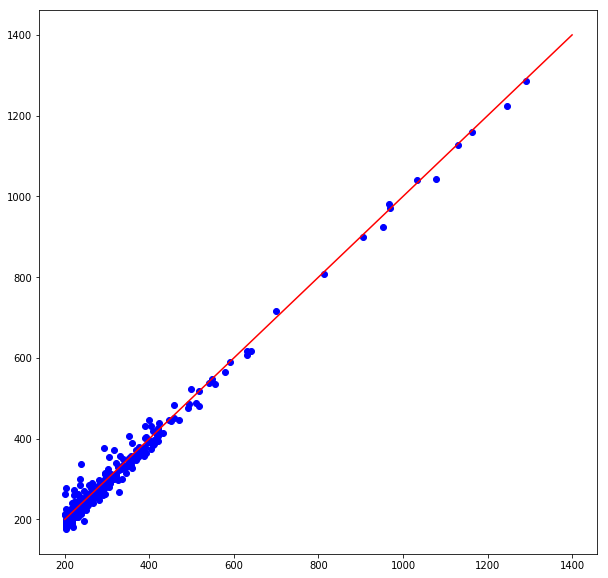

In [10]:
# visualiser le retard à l'arrivé en fonction du retard au départ
df2 = data_fly[data_fly.loc[:,'DEP_DELAY_NEW']>200]
plt.figure(figsize=(10,10))
plt.plot(df2.loc[:,'DEP_DELAY_NEW'], df2.loc[:,'ARR_DELAY_NEW'], 'ro',markersize=6, c='blue') 

plt.plot([200, 1400], [200, 1400],linestyle='-',c='red')
plt.show()

In [11]:
# enlever la première colonne
data_fly = data_fly.drop(columns = ['Unnamed: 0'])

In [12]:
# analyser la dimmension du dataset
print (data_fly.shape)

(56641, 32)


In [13]:
#ajouter une nouvelle colonne (PROBLEM)
vect= np.zeros(data_fly.shape[0])

data_fly['PROBLEM_BIG'] = vect[:]

In [14]:
# on choisit de  considérer comme "retard" les retards de plus de 300 ou annulés ou déviés
print (data_fly.shape[0])
data_fly.loc[:,'PROBLEM_BIG'][(data_fly['DEP_DELAY_NEW'] > 300)|(data_fly['CANCELLED'] ==1)|(data_fly['DIVERTED'] ==1 )] = 1
print (data_fly.shape[0])

56641
56641


C:\Users\tanne\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# supprimer les valeurs inconnues
print (data_fly.shape)
data_fly = data_fly.dropna(0, subset=['CASCADE','CASCADE_DEST','PROBLEM_BIG'])
print (data_fly.shape)

(56641, 33)
(56328, 33)


In [16]:
# mélanger les données : 
data_fly = shuffle(data_fly)

In [17]:
# choisir les variables qui nous interessent pour l'étude des correlations
data_fly_corr = data_fly[['PROBLEM_BIG','DISTANCE', 'AIR_TIME', 'DAY', 'DAY_YEAR', 'MINUTES',
       'MOY_WD_DAY', 'TR_WD_DAY', 'MOY_ORIG', 'TR_ORIG', 'MOY_DEST', 'TR_DEST',
       'MOY_TAIL', 'TR_TAIL', 'LAT_DEP', 'LONG_DEP', 'LAT_ARR', 'LONG_ARR',
       'HOURS_BEFORE', 'CASCADE']]

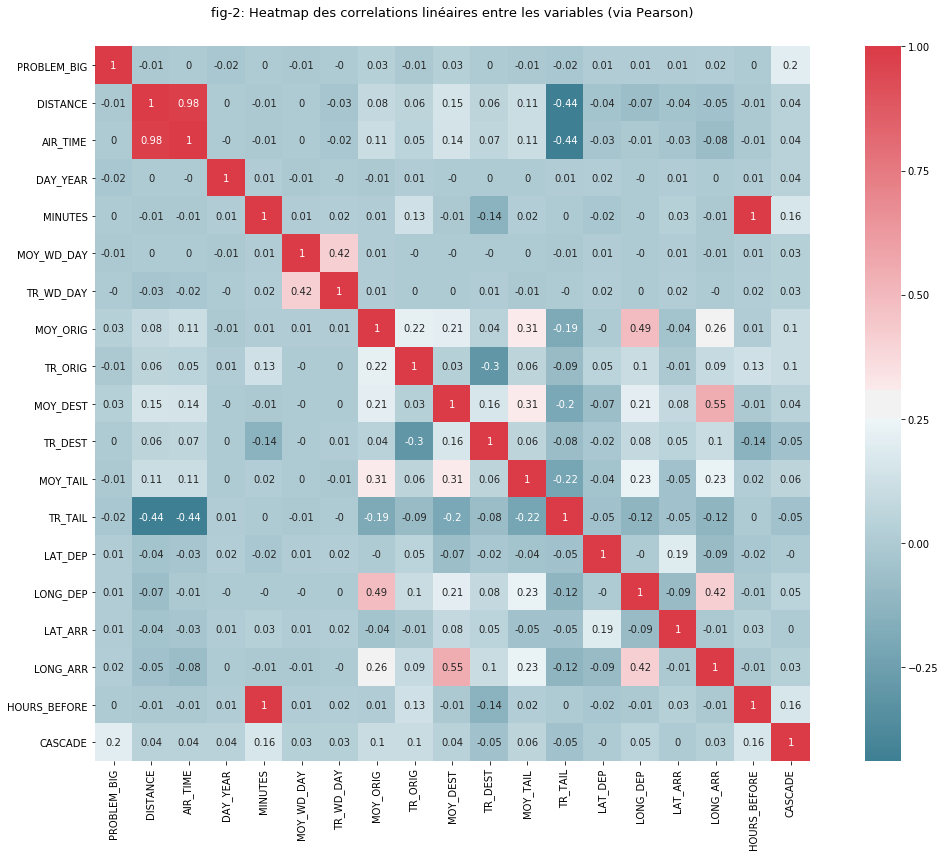

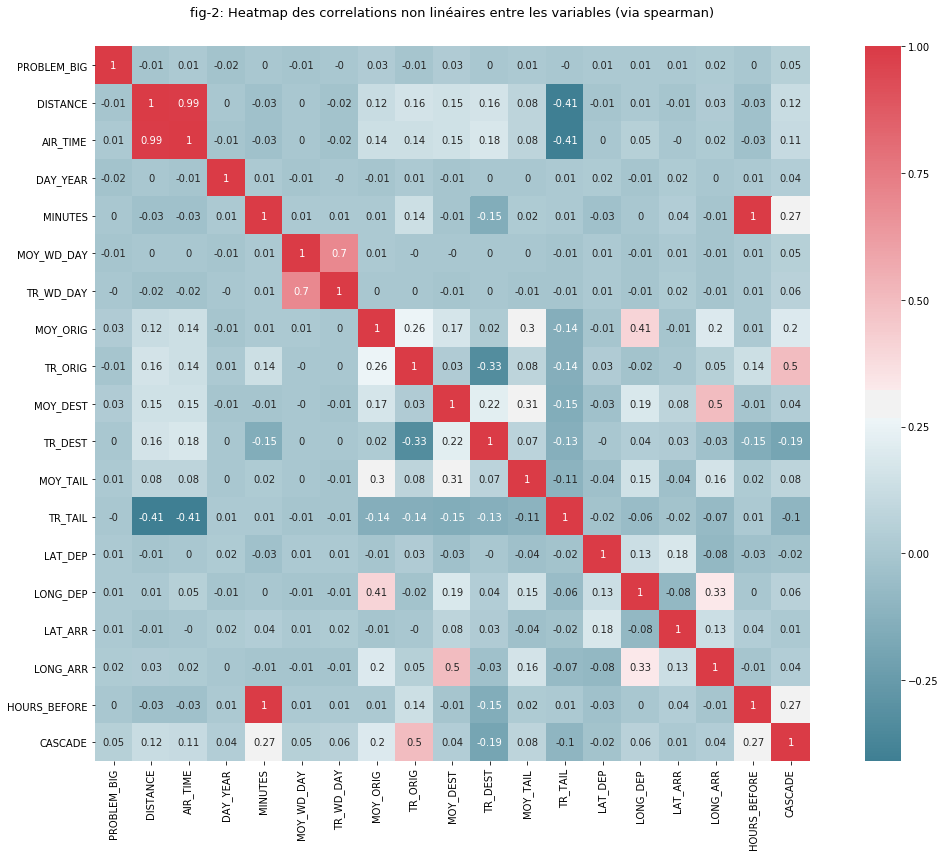

In [18]:
f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='pearson')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations linéaires entre les variables (via Pearson)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('correlation', dpi=400)
plt.show()

f, ax = plt.subplots(figsize=(16, 12))


corr = data_fly_corr.corr(method='spearman')
corr = np.around(corr,2)
sns.heatmap(corr, annot=True ,mask=np.zeros_like((corr), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('fig-2: Heatmap des correlations non linéaires entre les variables (via spearman)',fontsize=13,loc='center', pad = 30)
plt.tight_layout(h_pad=2)
plt.savefig('correlation', dpi=400)
plt.show()

In [19]:
df = data_fly.copy()
df = df.dropna(0, how='any')

In [20]:
# créer une liste qui prend en compte les résultats de nos différents modèles
liste_roc = []
liste_f1 = []
# noms
liste_name = []

In [21]:
data_fly = df[['PROBLEM_BIG','MINUTES','DAY_YEAR','MOY_WD_DAY','MOY_ORIG','MOY_DEST','MOY_TAIL','CASCADE']]

In [22]:
# creation des tenseurs numpy 
# creation des vecteurs X et y 
# variables éventuelles 
X = np.matrix(data_fly.iloc[:,:])
# scores éventuels 
y = np.transpose(np.matrix(data_fly.iloc[:,0]))

#X = np.transpose(X)
#y = np.transpose(y)
print (X.shape)
print (y.shape)

(55768, 8)
(55768, 1)


In [23]:
# créer un jeux de test et un jeux d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=41)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37364, 8) (18404, 8) (37364, 1) (18404, 1)


# En prenant en compte les jours de la semaine


In [24]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_linear')

(37364, 2)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.4393167996744512
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly2')

(37364, 3)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.452569047242255
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly3')

(37364, 4)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.453794075313303
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 5)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.4743554962735213
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


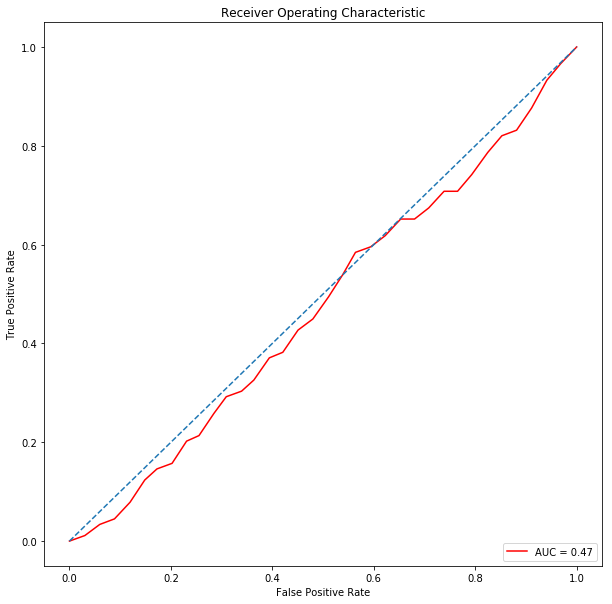

In [27]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,3],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly4')

(37364, 15)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 100000.0}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5318097348133746
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


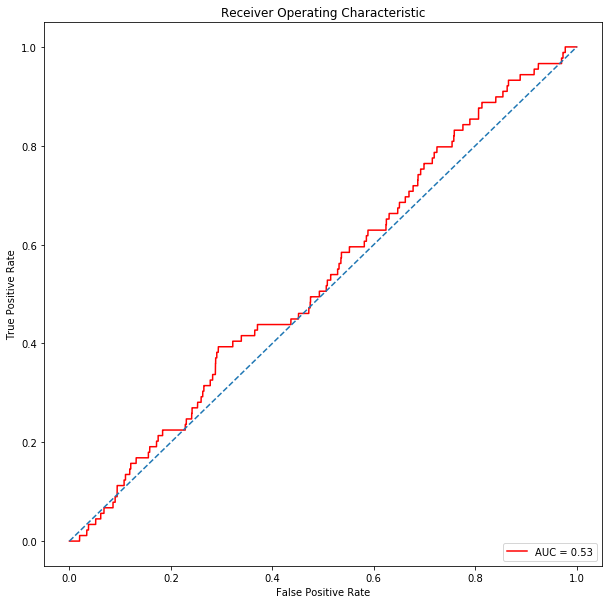

In [28]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:3],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('week_day_poly4reg')

# En prenant en compte les jours de l'année uniquement


In [29]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_linear')

(37364, 2)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5034624224749245
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly2')

(37364, 3)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5407302240408745
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly3')

(37364, 4)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5022223227002465
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 5)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5001155999668423
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


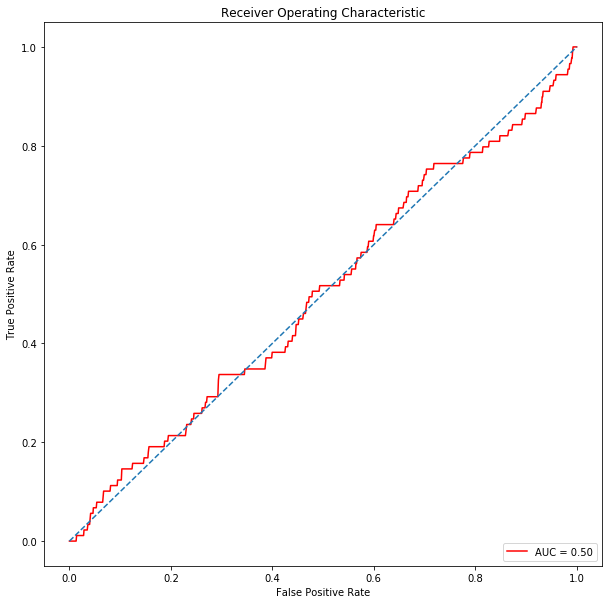

In [32]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,2],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly4')

(37364, 5)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 0.0016681005372000592}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5564070565716396
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


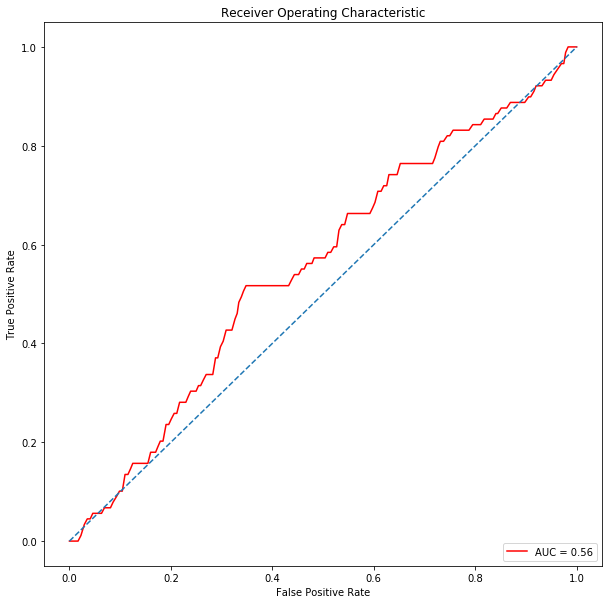

In [33]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,2],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('year_day_poly4reg')

# Considérer les jours de l'année + les jours de la semaine


In [34]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_linear')

(37364, 3)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.44954943141998055
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
# régression logistique poly(n=2) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly2')

(37364, 6)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.49065147438940765
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
# régression logistique poly(n=3) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly3')

(37364, 10)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.44421495263717137
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 15)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.46305669221320434
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


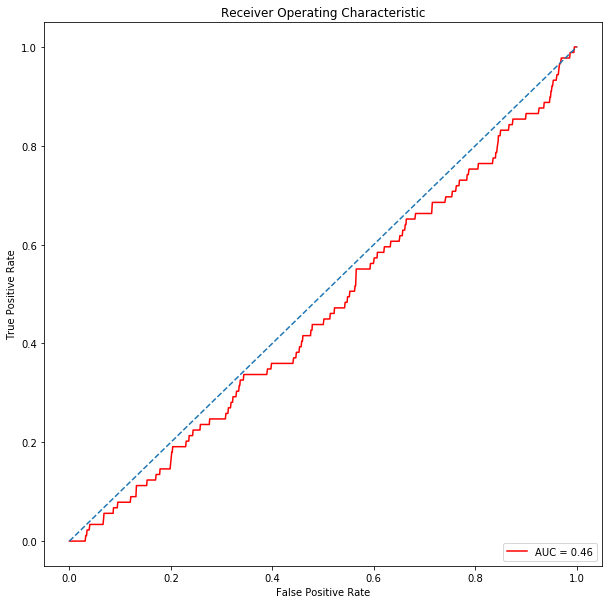

In [37]:
# régression logistique poly(n=4) 
f1, accu, roc = analyse(X_fit=X_train[:,2:4],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly4')

(37364, 15)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 100000.0}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5370290657804505
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


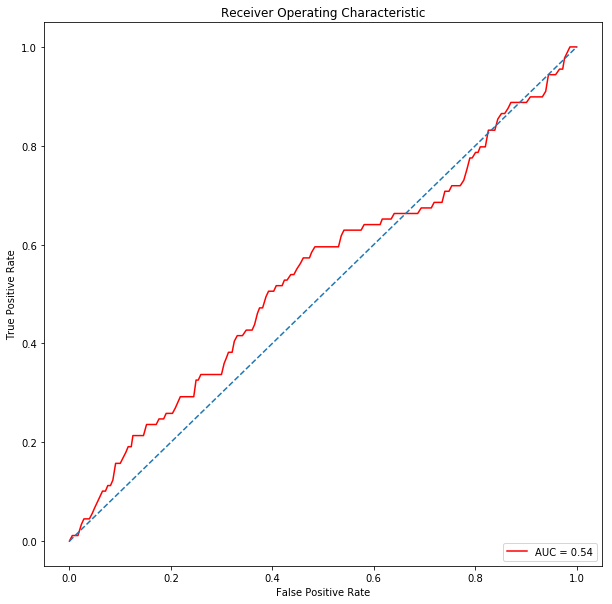

In [38]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,2:4],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('tot_day_poly4reg')

# considérer l'heure seule


In [39]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_linear')

(37364, 2)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.4570158026812561
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly2')

(37364, 3)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5111108599160505
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly3')

(37364, 4)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5325548798408428
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 5)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.522934008545656
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


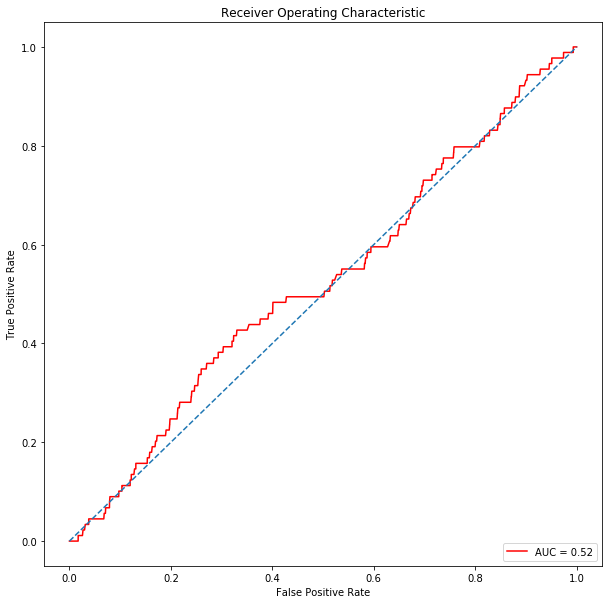

In [42]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly4')

(37364, 5)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001291549665014884}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.502157363657601
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


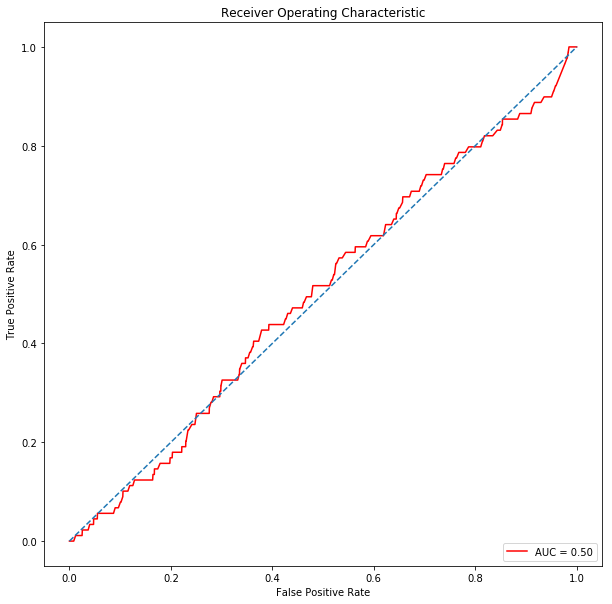

In [43]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_poly4reg')

# heure et jours de l'année

In [44]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_linear')

(37364, 3)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.4572733780962931
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly2')

(37364, 6)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5464954521134296
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly3')

(37364, 10)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5506458978590645
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 15)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.559214764240876
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


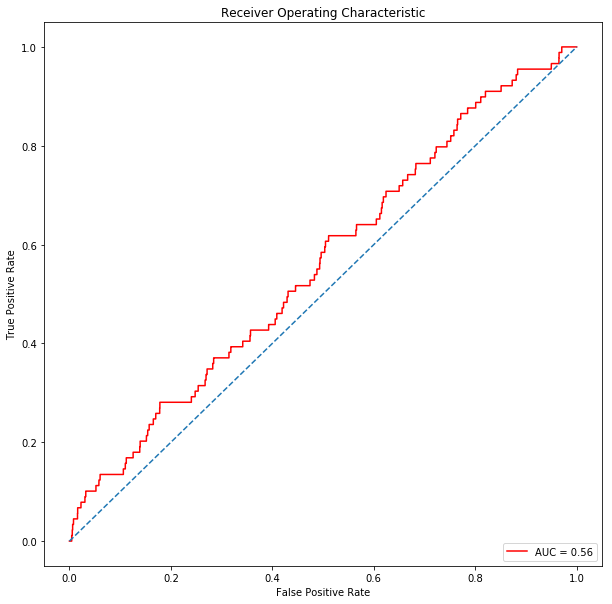

In [47]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1:3],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly4')

(37364, 15)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001291549665014884}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5542210566771415
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


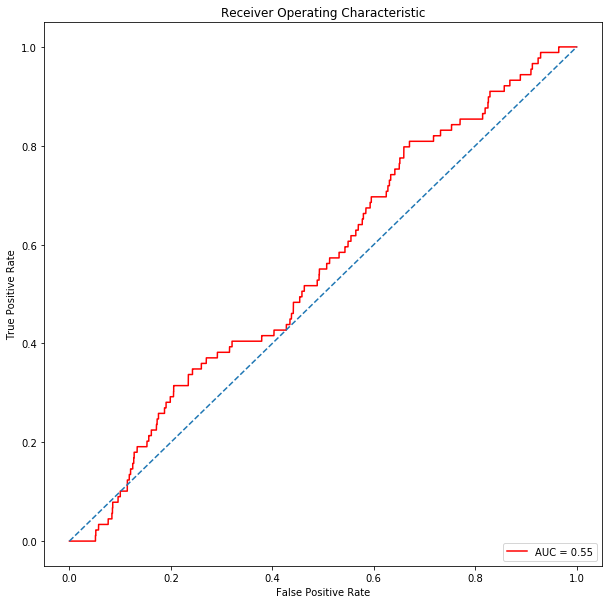

In [48]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:3],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_year_poly4reg')

# heure jours de l'année et jours de la semaine


In [49]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_linear')

(37364, 4)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.43645543674029197
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly2')

(37364, 10)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5101639047769765
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
# régression logistique poly(n=3)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=3)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly3')

(37364, 20)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5128204432588037
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 35)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5261326762070551
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


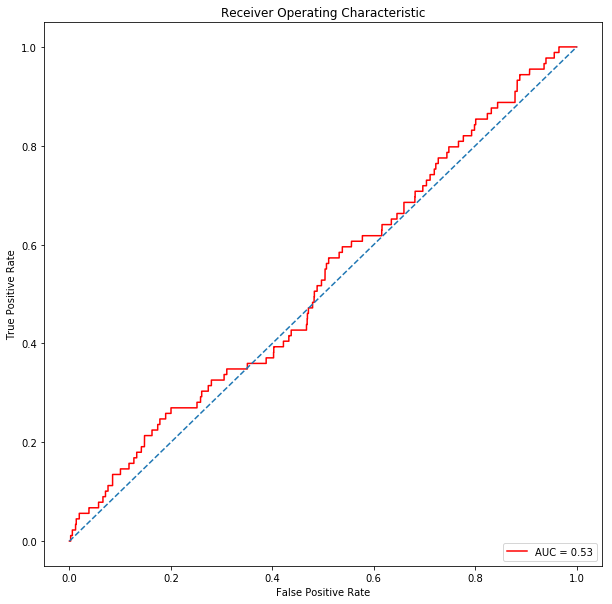

In [52]:
# régression logistique poly(n=4)
f1, accu, roc = analyse(X_fit=X_train[:,1:4],y_fit=y_train,n=4)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly4')

(37364, 35)
(37364,)
{'alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05])}
-------voici le meilleur paramètre---------
{'alpha': 100000.0}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.524936736524013
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


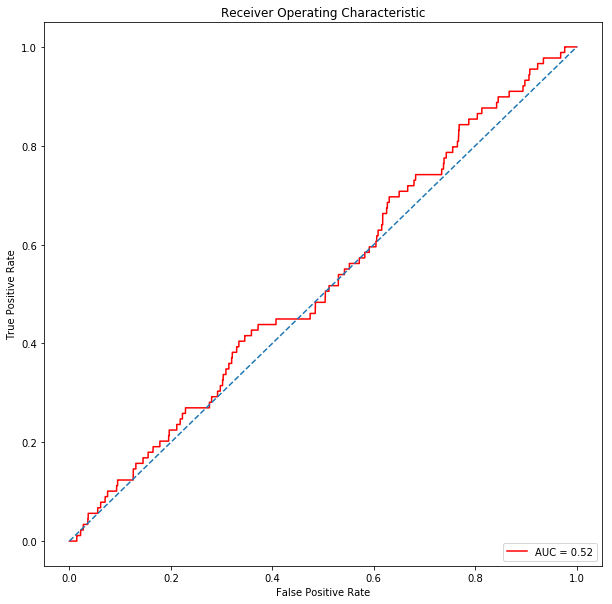

In [53]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:4],y_fit=y_train,n=4,params_min=-5,params_max=5,nb_params=10)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_poly4reg')

# Heure / jours de l'année / jours de la semaine / orig


In [54]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_linear')

(37364, 5)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.409380477622288
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:5],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly2')

(37364, 15)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.4607008342187959
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [56]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
start = timeit.timeit()
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:5],y_fit=y_train,n=3)[:]
end = timeit.timeit()
print ('-----time ---------')
print (end - start)
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly3')

(37364, 35)
(37364,)
accuracy
0.997484209399422
Aire sous la courbe ROC
0.4662439053798446
f1 score
0.0
-----time ---------
0.0032226176455923787


(37364, 70)
(37364,)
accuracy
0.997484209399422
Aire sous la courbe ROC
0.47208599914091287
f1 score
0.0


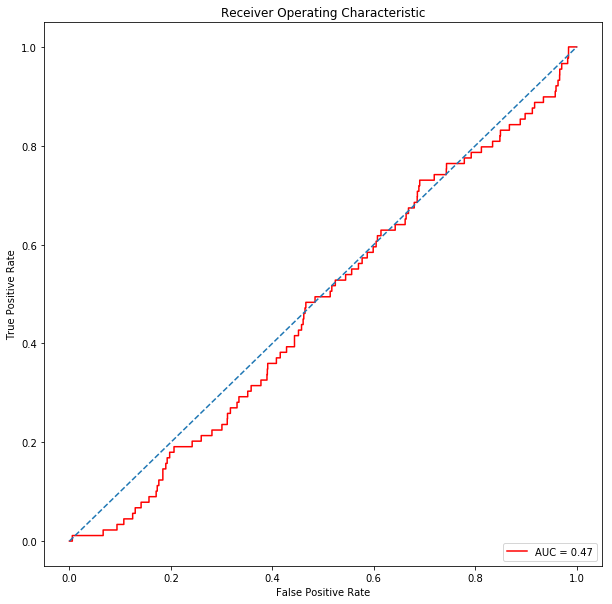

In [57]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:5],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly4')

In [58]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:5],y_fit=y_train,n=3,params_min=-1,params_max=1,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly3reg')

(37364, 35)
(37364,)
{'alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
-------voici le meilleur paramètre---------
{'alpha': 10.0}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5193813065659877
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 70)
(37364,)
{'alpha': array([ 0.1       ,  0.31622777,  1.        ,  3.16227766, 10.        ])}
-------voici le meilleur paramètre---------
{'alpha': 10.0}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5296978877007362
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


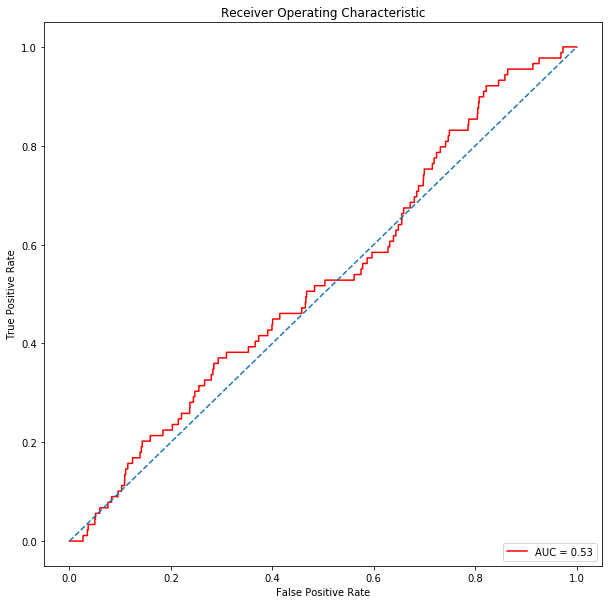

In [59]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:5],y_fit=y_train,n=4,params_min=-1,params_max=1,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_origin_poly4')

# heure / jours de l'année / jours de la semaine / orig / arriv


In [60]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_linear')

(37364, 6)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5457313167393877
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:6],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly2')

(37364, 21)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.5377635098983413
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:6],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly3')

(37364, 56)
(37364,)
accuracy
0.9975109731292153
Aire sous la courbe ROC
0.5205187680389453
f1 score
0.0


(37364, 126)
(37364,)
accuracy
0.9973771544802483
Aire sous la courbe ROC
0.5183065433801309
f1 score
0.0


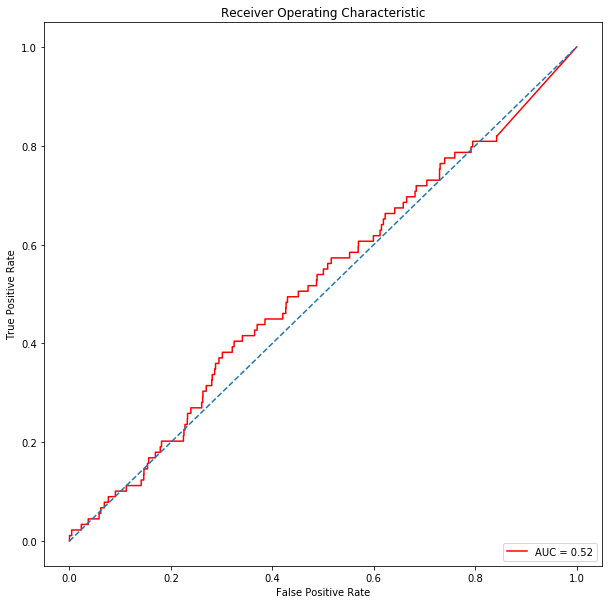

In [63]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:6],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly4')

In [64]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:6],y_fit=y_train,n=3,params_min=-3,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly3reg')

(37364, 56)
(37364,)
{'alpha': array([1.00000000e-03, 5.62341325e-02, 3.16227766e+00, 1.77827941e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.001}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.6106584073730774
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 126)
(37364,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.6143012381404532
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


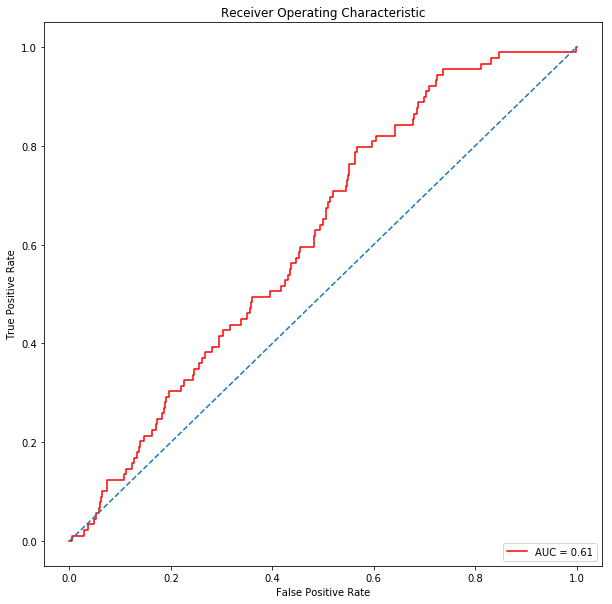

In [65]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:6],y_fit=y_train,n=4,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_poly4reg')

# heure / jours de l'année / jours de la semaine / orig / arriv / appareil


In [66]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_linear')

(37364, 7)
(37364,)
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.6366570961348615
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:7],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly2')

(37364, 28)
(37364,)
accuracy
0.9975645005888021
Aire sous la courbe ROC
0.5813731829177311
f1 score
0.0


In [68]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:7],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly3')

(37364, 84)
(37364,)
accuracy
0.9972700995610748
Aire sous la courbe ROC
0.5535640811159089
f1 score
0.0


(37364, 210)
(37364,)
accuracy
0.9970292259929344
Aire sous la courbe ROC
0.5597537283626854
f1 score
0.0


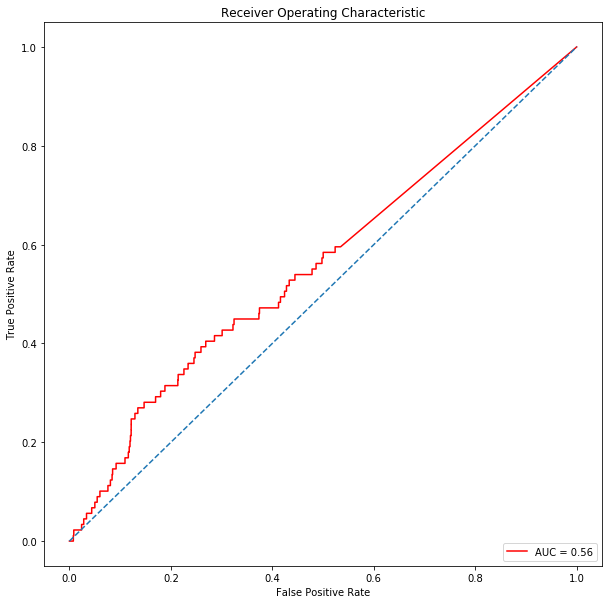

In [69]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=4)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:7],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('hour_day_tot_path_aircraft_poly4')

In [70]:
# on rajouter de la regularisation (poly n=3)
f1, accu, roc = best_model(X_fit=X_train[:,1:7],y_fit=y_train,n=3,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)

liste_name.append('hour_day_tot_path_aircraft_poly3reg')

(37364, 84)
(37364,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.6479497207966902
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(37364, 210)
(37364,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.9976180280483888
Aire sous la courbe ROC
0.6411303777722516
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


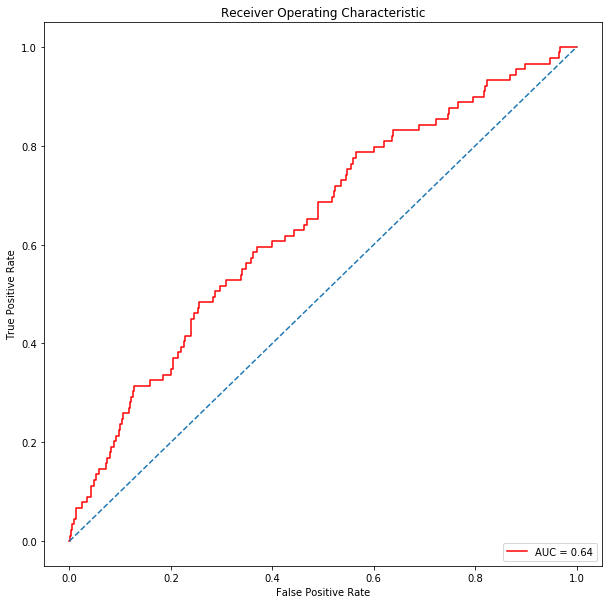

In [71]:
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:7],y_fit=y_train,n=4,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)

liste_name.append('hour_day_tot_path_aircraft_poly4reg')

# 2 cas où tente de prédir le retard au départ légérement avant


In [72]:
# régression logistique linéaire 
f1, accu, roc = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=1)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_linear')

(37364, 8)
(37364,)
accuracy
0.9976447917781822
Aire sous la courbe ROC
0.8742031213498218
f1 score
0.1851851851851852


In [73]:
# régression logistique poly(n=2)
f1, accu, roc = analyse(X_fit=X_train[:,1:8],y_fit=y_train,n=2)[:]
liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly2')

(37364, 36)
(37364,)
accuracy
0.9974574456696286
Aire sous la courbe ROC
0.8038680020196082
f1 score
0.17391304347826086


In [74]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:8],y_fit=y_train,n=3)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3')

(37364, 120)
(37364,)
accuracy
0.9971095171823146
Aire sous la courbe ROC
0.7245879773020143
f1 score
0.18181818181818182


(37364, 330)
(37364,)
accuracy
0.9964404239374799
Aire sous la courbe ROC
0.6874057830126828
f1 score
0.11920529801324505


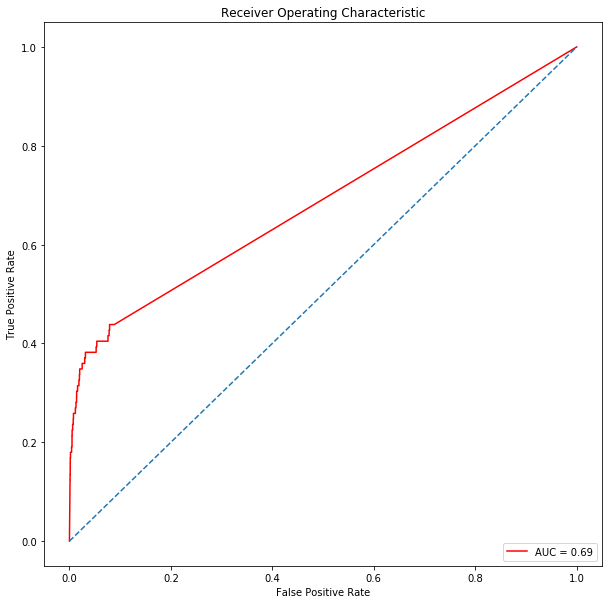

In [75]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
f1, accu, roc = analyse_stoch(X_fit=X_train[:,1:8],y_fit=y_train,n=4)[:]

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3')

In [76]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:8],y_fit=y_train,n=3,params_min=-1,params_max=4,nb_params=5)

liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly3reg')

(37364, 120)
(37364,)
{'alpha': array([1.00000000e-01, 1.77827941e+00, 3.16227766e+01, 5.62341325e+02,
       1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.1}
accuracy
0.997484209399422
Aire sous la courbe ROC
0.8501429551089308
f1 score
0.09615384615384615


(37364, 330)
(37364,)
{'alpha': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02])}
-------voici le meilleur paramètre---------
{'alpha': 0.01778279410038923}
accuracy
0.9975377368590087
Aire sous la courbe ROC
0.8655631165268767
f1 score
0.09803921568627451


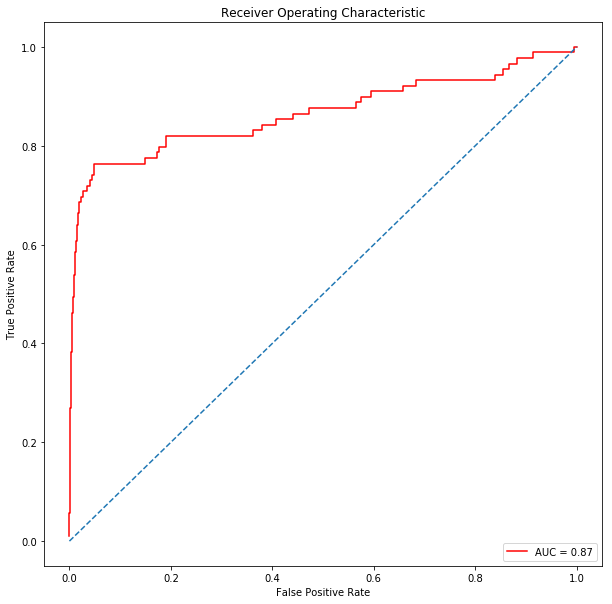

In [77]:
# le temps de calcul est trop long, on passe à une descende de gradient stochastique
# régression logistique poly(n=3)
# on rajouter de la regularisation (poly n=4)
f1, accu, roc = best_model(X_fit=X_train[:,1:8],y_fit=y_train,n=4,params_min=-3,params_max=2,nb_params=5)


liste_f1.append(f1)
liste_roc.append(roc)
liste_name.append('before_poly4reg')

# Performance des modèles finaux sur le test set


(18404, 210)


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy
0.9981525755270594
Aire sous la courbe ROC
0.6328957059143745
f1 score
0.0


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


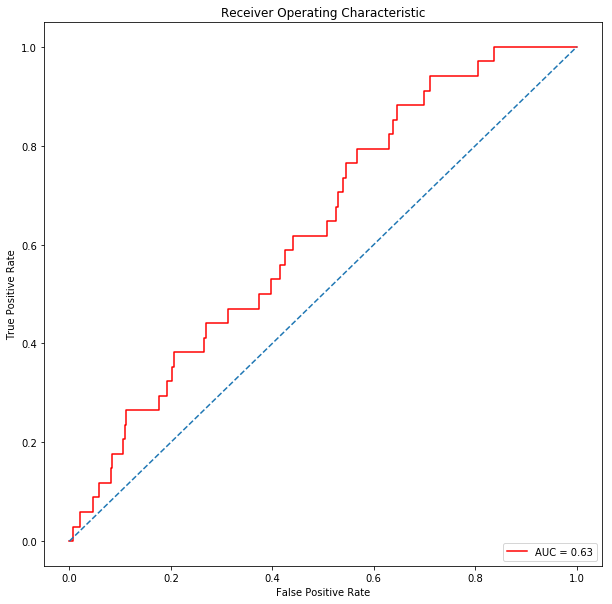

In [78]:
# performance sur le modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X_train[:,1:7]
X_fit_t = X_test[:,1:7]

y_train = y_train
y_test = y_test

alpha = 0.99787999
f1, accu, roc = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)[:]

(18404, 330)


C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy
0.9982069115409693
Aire sous la courbe ROC
0.8794790098946492
f1 score
0.10810810810810811


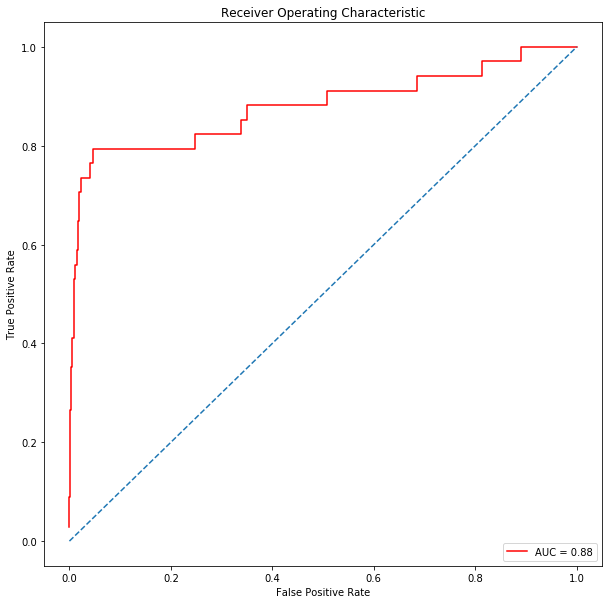

In [79]:
# performance sur le modèle final dans le cas où on cherche à prédire le retard au départ quelques heures à l'avance
X_fit = X_train[:,1:8]
X_fit_t = X_test[:,1:8]

y_train = y_train
y_test = y_test

alpha = 0.316
f1, accu, roc = perform(X_train=X_fit,X_test=X_fit_t,y_train=y_train,y_test=y_test,alpha=alpha,n=4)[:]

# Enregistrement des modèles utilisés dans l'API

In [80]:
from sklearn.externals import joblib

In [81]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ longtemps à l'avance 
X_fit = X[:,1:7]
y_fit = y

alpha = 0.99787999
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
X_fit = std_scale.transform(X_fit)

# On crée un modèle de SGDC
model_big_prob_small = linear_model.SGDClassifier(loss='log',max_iter=10,penalty='l2',alpha=alpha,learning_rate='optimal')
# entrainer le modèle 
model_big_prob_small.fit(X_fit,y_fit)   
    
#SAVE 
joblib.dump(model_big_prob_small, 'model_big_prob_big.joblib') 

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['model_big_prob_big.joblib']

In [82]:
# sauvegarde du modèle final dans le cas où on cherche à prédire de retard au départ quelques heures à l'avance 
X_fit = X[:,1:8]
y_fit = y

alpha = 0.316
# ajouter des features polynomiales couplées 
poly = PolynomialFeatures(4)
X_fit = poly.fit_transform(X_fit)
y_fit = y_fit
    
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
X_fit = std_scale.transform(X_fit)
    
# On crée un modèle de SGDC
model_medium_prob_small = linear_model.SGDClassifier(loss='log',max_iter=10,penalty='l2',alpha=alpha,learning_rate='optimal')
# entrainer le modèle 
model_medium_prob_small.fit(X_fit,y_fit)  
    

joblib.dump(model_medium_prob_small, 'model_medium_prob_big.joblib') 

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['model_medium_prob_big.joblib']

# visualisation des differents modeles

No handles with labels found to put in legend.
C:\Users\tanne\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "modele". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


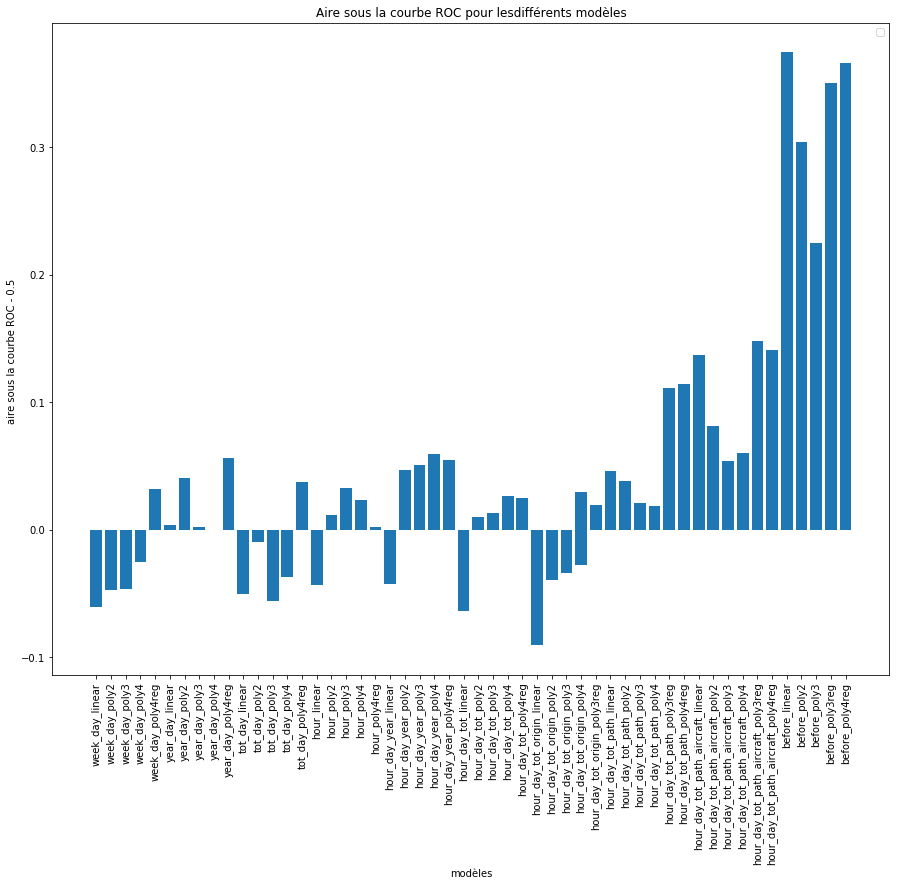

In [83]:
for i in range (len(liste_roc)):
    liste_roc[i] = liste_roc[i] - 0.5
plt.figure(figsize=(15,12))
plt.title('Aire sous la courbe ROC pour lesdifférents modèles')
plt.bar(liste_name[:],liste_roc[:])
plt.legend(loc = 'modele')
        
plt.axis('tight')
plt.ylabel('aire sous la courbe ROC - 0.5 ')
plt.xlabel('modèles')

plt.xticks(rotation=90)
plt.savefig('pict_rocmodelsbig.png', dpi=400)
plt.show()  